# Towards Automated Materials Analysis: Deep Learning Denoising and Phase Identification from 4D-STEM

# 1. Dataset Curation 

## 1.1 Generation of clean image

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.draw import disk
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm
import py4DSTEM
import signal

# --- Timeout setup ---
class TimeoutException(Exception):
    pass
 
def timeout_handler(signum, frame):
    raise TimeoutException()

signal.signal(signal.SIGALRM, timeout_handler)

# --- Configuration ---
API_KEY = "Kg3Lv1IRFzRaKbh0GrkTiJ8dZ9d5hPiG"
csv_path = "/Users/ethan/Desktop/Materials Simulation MPhil Project/table_export_cubic.csv" and "/Users/ethan/Desktop/Materials Simulation MPhil Project/table_export_hcp.csv"
image_size = 256
radius = 2
output_dir = "/Users/ethan/Desktop/Materials Simulation MPhil Project/Generated DPs Clean x"
checkpoint_file = "/Users/ethan/Desktop/Materials Simulation MPhil Project/checkpoint x.txt"
timeout_log_file = "/Users/ethan/Desktop/Materials Simulation MPhil Project/skipped_timeout_log x.txt"
redo_all = False

os.makedirs(output_dir, exist_ok=True)

# --- ZA generator ---
def ZA_list(max_index):
    from itertools import product
    ZAs = []
    for h, k, l in product(range(-max_index, max_index+1), repeat=3):
        if [h, k, l] != [0, 0, 0]:
            ZAs.append([h, k, l])
    return ZAs

# --- Bravais type determination ---
def get_bravais_type(structure):
    analyzer = SpacegroupAnalyzer(structure)
    lattice_type = analyzer.get_lattice_type().lower()
    if "face" in lattice_type:
        return "fcc"
    elif "body" in lattice_type:
        return "bcc"
    elif "primitive" in lattice_type:
        return "sc"    
    else:
        return "unknown"

# --- Selection rule ---
def selection_multiplier(h, k, l, bravais_type):
    if bravais_type == "fcc":
        return 1 if (h % 2 == k % 2 == l % 2) else 0
    elif bravais_type == "bcc":
        return 1 if (h + k + l) % 2 == 0 else 0
    elif bravais_type == "sc":
        return 1
    else:
        return 1

# --- Load CSV and checkpoint ---
df = pd.read_csv(csv_path)
ZAs = ZA_list(2)
done_set = set()
if not redo_all and os.path.exists(checkpoint_file):
    with open(checkpoint_file, "r") as f:
        for line in f:
            done_set.add(line.strip())

# --- Main loop ---
with MPRester(API_KEY) as m, tqdm(total=len(df) * len(ZAs), desc="Generating DPs", unit="DP") as pbar:
    for _, row in df.iterrows():
        mp_id = row["Material ID"]
        formula = row["Formula"]

        try:
            structure = m.get_structure_by_material_id(mp_id)
            bravais_type = get_bravais_type(structure)
            Material = py4DSTEM.process.diffraction.Crystal.from_pymatgen_structure(structure)
            Material.calculate_dynamical_structure_factors(100e3, "WK-CP", k_max=4.0, thermal_sigma=0.08)
        except Exception as e:
            print(f"Skipping {mp_id}: {e}")
            pbar.update(len(ZAs))
            continue

        for ZA in ZAs:
            tag = f"{formula.replace(' ', '')}_{mp_id}_ZA_{ZA[0]}{ZA[1]}{ZA[2]}"
            if not redo_all and tag in done_set:
                pbar.update(1)
                continue

            try:
                signal.alarm(120)  # 2-minute timeout
                beams = Material.generate_diffraction_pattern(zone_axis_lattice=ZA, k_max=2)
                pattern = Material.generate_dynamical_diffraction_pattern(beams=beams, thickness=10.0, zone_axis_lattice=ZA)
                signal.alarm(0)

                h, k, l = np.round(pattern.data["h"]).astype(int), np.round(pattern.data["k"]).astype(int), np.round(pattern.data["l"]).astype(int)
                multipliers = np.array([selection_multiplier(hi, ki, li, bravais_type) for hi, ki, li in zip(h, k, l)])
                mask = multipliers > 0
                pattern.data = pattern.data[mask]
                intensity = pattern.data["intensity"] * multipliers[mask]
                pattern.data = pattern.data[intensity > 1e-5]
                intensity = intensity[intensity > 1e-5]

                qx = pattern.data["qx"]
                qy = pattern.data["qy"]
                qx_norm = ((qx - qx.min()) / (qx.max() - qx.min()) * (image_size - 1)).astype(int)
                qy_norm = ((qy - qy.min()) / (qy.max() - qy.min()) * (image_size - 1)).astype(int)

                image = np.zeros((image_size, image_size))
                for x, y, I in zip(qx_norm, qy_norm, intensity):
                    rr, cc = disk((y, x), radius, shape=image.shape)
                    image[rr, cc] += 1e8 * I

                clear_path = os.path.join(output_dir, f"{tag}_clear.png")
                plt.imsave(clear_path, np.log1p(image), cmap="gray")

                with open(checkpoint_file, "a") as f:
                    f.write(tag + "\n")

                pbar.update(1)

            except TimeoutException:
                msg = f"Timeout on {mp_id} ZA={ZA}. Skipping...\n"
                print(msg.strip())
                with open(timeout_log_file, "a") as f:
                    f.write(msg)
                pbar.update(1)
                continue

            except Exception as e:
                print(f"Error for {mp_id} ZA={ZA}: {e}")
                signal.alarm(0)
                pbar.update(1)

print("All DPs generated and saved.")

## 1.2 Generation of noisy image

In [ ]:
#!/usr/bin/env python
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d       # for streaks
import matplotlib.pyplot as plt
from skimage.feature import blob_log      # for spot dimming


# ───────────────────── CONTROL CENTRE ──────────────────────────────────────

# Paths
CLEAN_DIR = "/Users/ethan/Desktop/Materials Simulation MPhil Project/Generated DPs Clean 3"
NOISY_DIR = "/Users/ethan/Desktop/Materials Simulation MPhil Project/Generated DPs Noisy 10"

# Max Images
MAX_IMAGES = None

# Randomness
RANDOM_SEED = 12345
N_PREVIEW   = 10

# Global toggles
USE_LOG         = False   # linear scaling – like your example image
USE_HALO        = True    # apply halo
USE_SALT_PEPPER = Falase   # SP noise off for now
USE_DIM_SPOTS   = True    # random spot dimming

# Core noise parameters
BACKGROUND_WEIGHT      = 0.3    # mostly signal, some radial background
COUNTS_PER_PROBE       = 100    # electron counts scale
INTENSITY_COEFFICIENT  = 10     # overall brightness

# Halo parameters
HALO_STRENGTH          = 1.5
HALO_DECAY             = 1.5
HALO_R_FLAT            = 10

# Detector blur – sets spot size / faintness
BLUR_SIGMA             = 1.4

# Salt & pepper parameters
SP_AMOUNT              = 0.5
SP_SMOOTH              = 0.5
SALT_VS_PEPPER         = 0.5

# Streak parameters (000 streak / motion blur)
USE_STREAKS       = True     # master on/off
STREAK_PROB       = 0.4      # probability a DP gets a streak
STREAK_RADIUS     = 18       # radius (pixels) around 000 affected
MOTION_LEN        = 7        # diagonal kernel length
MOTION_STRENGTH   = 0.6      # blend between original / streaked in disk

# Central bloom / saturation for 000
USE_CENTRAL_BLOOM   = True   # soften / saturate the central spot region
BLOOM_RADIUS        = HALO_R_FLAT # pixels around centre to soften
BLOOM_SIGMA         = 2    # blur strength inside bloom disc
BLOOM_ATTENUATION   = 1   # 0–1: lower = darker centre after bloom

# Beam stop / central block 
BLOCK_PROB             = 0.2
BLOCK_RADIUS           = 20

# Spot dimming parameters
SPOT_P_DIM             = 0.3
SPOT_MAX_SPOTS         = 10
SPOT_DIM_RANGE         = (0.35, 0.7)
SPOT_MIN_SIGMA         = 1.0
SPOT_MAX_SIGMA         = 4.0
SPOT_NUM_SIGMA         = 10
SPOT_THRESHOLD         = 0.03
SPOT_AVOID_CENTER_EXTRA = 5.0


# ───────────────────── CORE NOISE MODEL ────────────────────────────────────

def add_poisson_background_noise(
    dp_stack,
    background_weight,
    counts_per_probe,
    intensity_coefficient,
    add_halo,
    halo_strength,
    halo_decay,
    r_flat,
    blur_sigma,
    add_salt_pepper,
    sp_amount,
    sp_smooth,
    salt_vs_pepper,
    use_streaks,
    streak_prob,
    streak_radius,
    motion_len,
    motion_strength,
    use_central_bloom,
    bloom_radius,
    bloom_sigma,
    bloom_attenuation,
    rng
):
    """
    Core noise model:
      - optional halo on the signal
      - radial background mix
      - Poisson sampling
      - Gaussian PSF blur
      - optional 000 streak via diagonal motion blur in central disk
      - optional central bloom (local blur + attenuation in centre)
      - optional salt & pepper

    All behaviour is determined by the arguments (which come from CONTROL CENTRE).
    Returns *linear* intensities (not scaled to 0–1).
    """
    N, H, W = dp_stack.shape
    noisy_stack = np.zeros_like(dp_stack, dtype=np.float32)

    # 1) build the radial background once
    qx = np.fft.fftfreq(H); qy = np.fft.fftfreq(W)
    qyA, qxA = np.meshgrid(qy, qx)
    qxA, qyA = np.fft.fftshift(qxA), np.fft.fftshift(qyA)
    r2 = qxA**2 + qyA**2
    radial_scale = 1e-2
    im_bg = 1.0 / (1 + r2 / radial_scale**2)
    im_bg /= im_bg.sum()

    # 2) coordinates and optional halo mask
    Y, X = np.indices((H, W))
    cy, cx = H//2, W//2
    R = np.sqrt((X - cx)**2 + (Y - cy)**2)
    if add_halo:
        halo = np.exp(-R / halo_decay)
        halo[R < r_flat] = 1.0
        halo /= halo.max()
    else:
        halo = None

    # 3) motion-blur kernel & streak mask for 000 streak
    if use_streaks and motion_len > 1 and motion_strength > 0:
        k = np.zeros((motion_len, motion_len), dtype=np.float32)
        np.fill_diagonal(k, 1.0)
        k /= k.sum()
        streak_mask = (X - cx)**2 + (Y - cy)**2 <= streak_radius**2
    else:
        k = None
        streak_mask = None

    # 4) central bloom mask
    if use_central_bloom and bloom_radius > 0:
        bloom_mask = (X - cx)**2 + (Y - cy)**2 <= bloom_radius**2
    else:
        bloom_mask = None

    for i in tqdm(range(N), desc="Adding noise"):
        frame = dp_stack[i].astype(np.float32).copy()

        # halo on the signal
        if halo is not None:
            frame = frame + halo_strength * frame.max() * halo

        # mix + poisson + scale
        mixed = (1 - background_weight) * frame + background_weight * im_bg
        noisy = rng.poisson(mixed * counts_per_probe) / counts_per_probe
        noisy *= intensity_coefficient

        # blur (PSF)
        noisy = gaussian_filter(noisy, sigma=blur_sigma)

        # optional 000 streak
        if k is not None and streak_mask is not None and rng.random() < streak_prob:
            blurred_motion = convolve2d(noisy, k, mode="same", boundary="symm")
            noisy_streaked = noisy.copy()
            noisy_streaked[streak_mask] = (
                (1.0 - motion_strength) * noisy[streak_mask]
                + motion_strength * blurred_motion[streak_mask]
            )
            noisy = noisy_streaked

        # optional central bloom / saturation (local blur + attenuation)
        if bloom_mask is not None:
            centre_only = noisy * bloom_mask
            blurred_centre = gaussian_filter(centre_only, sigma=bloom_sigma)
            blended = (
                bloom_attenuation * blurred_centre +
                (1.0 - bloom_attenuation) * noisy
            )
            noisy[bloom_mask] = blended[bloom_mask]

        # optional salt & pepper
        if add_salt_pepper and sp_amount > 0:
            num_s = int(sp_amount * H * W * salt_vs_pepper)
            num_p = int(sp_amount * H * W * (1.0 - salt_vs_pepper))

            if num_s > 0 or num_p > 0:
                med = float(np.median(noisy))

                if num_s > 0:
                    salt_idx = (
                        rng.integers(0, H, num_s),
                        rng.integers(0, W, num_s)
                    )
                    noisy[salt_idx] = med * 1.3

                if num_p > 0:
                    pepper_idx = (
                        rng.integers(0, H, num_p),
                        rng.integers(0, W, num_p)
                    )
                    noisy[pepper_idx] = med * 0.7

                noisy = gaussian_filter(noisy, sigma=sp_smooth)

        noisy_stack[i] = noisy.astype(np.float32)

    return noisy_stack


# ───────────────────── CENTRAL BLOCK ───────────────────────────────────────

def block_center(img, radius):
    """Zero‐out a disk of given radius at the centre."""
    H, W = img.shape
    cy, cx = H//2, W//2
    Y, X = np.ogrid[:H, :W]
    mask = (X - cx)**2 + (Y - cy)**2 <= radius**2
    out = img.copy()
    out[mask] = 0.0
    return out


# ───────────────────── BLOB-BASED SPOT DIMMING ─────────────────────────────

def dim_spots(
    img: np.ndarray,
    p_dim: float,
    max_spots: int,
    dim_range,
    min_sigma: float,
    max_sigma: float,
    num_sigma: int,
    threshold: float,
    avoid_center: float,
    rng
) -> np.ndarray:
    """
    Detect bright blobs and randomly dim a subset outside a central radius.
    Assumes img is scaled to ~0–1 (log or linear normalised).
    All control comes from arguments (which are set in CONTROL CENTRE).
    """
    H, W = img.shape
    cy, cx = H / 2.0, W / 2.0

    blobs = blob_log(
        img,
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        num_sigma=num_sigma,
        threshold=threshold
    )

    if blobs.size:
        dists = np.hypot(blobs[:, 0] - cy, blobs[:, 1] - cx)
        candidates = blobs[dists > avoid_center]
    else:
        candidates = np.empty((0, 3))

    out = img.copy()

    if candidates.size:
        keep = rng.random(len(candidates)) < p_dim
        chosen = candidates[keep]
        if len(chosen) > max_spots:
            chosen = chosen[rng.choice(len(chosen), max_spots, replace=False)]

        yy, xx = np.ogrid[:H, :W]
        for y, x, sigma in chosen:
            radius = float(sigma) * np.sqrt(2.0)
            att = float(rng.uniform(dim_range[0], dim_range[1]))
            mask = (yy - y)**2 + (xx - x)**2 <= radius**2
            out[mask] *= att

    return out


# ───────────────────── MAIN PIPELINE ───────────────────────────────────────

if __name__ == "__main__":
    os.makedirs(NOISY_DIR, exist_ok=True)

    # 1) load clean stack (0–1)
    clean_files = sorted(f for f in os.listdir(CLEAN_DIR) if f.endswith("_clear.png"))

    if MAX_IMAGES is not None:
        clean_files = clean_files[:MAX_IMAGES]

    print(f"Processing {len(clean_files)} images from '{CLEAN_DIR}'")

    dp_stack = np.stack([
        np.array(
            Image.open(os.path.join(CLEAN_DIR, f)).convert("L"),
            dtype=np.float32
        ) / 255.0
        for f in tqdm(clean_files, desc="Loading clean images")
    ])

    rng = np.random.default_rng(RANDOM_SEED)

    # 2) add Poisson + radial background + blur (+ halo / streaks / bloom / S&P if toggled on)
    noisy_stack = add_poisson_background_noise(
        dp_stack=dp_stack,
        background_weight=BACKGROUND_WEIGHT,
        counts_per_probe=COUNTS_PER_PROBE,
        intensity_coefficient=INTENSITY_COEFFICIENT,
        add_halo=USE_HALO,
        halo_strength=HALO_STRENGTH,
        halo_decay=HALO_DECAY,
        r_flat=HALO_R_FLAT,
        blur_sigma=BLUR_SIGMA,
        add_salt_pepper=USE_SALT_PEPPER,
        sp_amount=SP_AMOUNT,
        sp_smooth=SP_SMOOTH,
        salt_vs_pepper=SALT_VS_PEPPER,
        use_streaks=USE_STREAKS,
        streak_prob=STREAK_PROB,
        streak_radius=STREAK_RADIUS,
        motion_len=MOTION_LEN,
        motion_strength=MOTION_STRENGTH,
        use_central_bloom=USE_CENTRAL_BLOOM,
        bloom_radius=BLOOM_RADIUS,
        bloom_sigma=BLOOM_SIGMA,
        bloom_attenuation=BLOOM_ATTENUATION,
        rng=rng
    )

    # 3) randomly block centre on some patterns (beam stop / saturation)
    for i in range(len(noisy_stack)):
        if rng.random() < BLOCK_PROB:
            noisy_stack[i] = block_center(noisy_stack[i], BLOCK_RADIUS)

    # 4) normalisation step with log optional
    if USE_LOG:
        lg_stack = np.log1p(noisy_stack)
        G = float(lg_stack.max())
        norm_stack = lg_stack / (G + 1e-12)
    else:
        G = float(noisy_stack.max())
        norm_stack = noisy_stack / (G + 1e-12)

    # 5) optional blob-based spot dimming on the normalised images
    if USE_DIM_SPOTS:
        dimmed_stack = np.zeros_like(norm_stack, dtype=np.float32)
        avoid_center = BLOCK_RADIUS + SPOT_AVOID_CENTER_EXTRA
        for i in tqdm(range(len(norm_stack)), desc="Dimming spots"):
            dimmed_stack[i] = dim_spots(
                img=norm_stack[i],
                p_dim=SPOT_P_DIM,
                max_spots=SPOT_MAX_SPOTS,
                dim_range=SPOT_DIM_RANGE,
                min_sigma=SPOT_MIN_SIGMA,
                max_sigma=SPOT_MAX_SIGMA,
                num_sigma=SPOT_NUM_SIGMA,
                threshold=SPOT_THRESHOLD,
                avoid_center=avoid_center,
                rng=rng
            )
        final_stack = dimmed_stack
    else:
        final_stack = norm_stack

    # 6) save out final images
    for fname, im in zip(clean_files, final_stack):
        outname = fname.replace("_clear.png", "_noisy.png")
        img8 = (np.clip(im, 0, 1) * 255).astype(np.uint8)
        Image.fromarray(img8).save(os.path.join(NOISY_DIR, outname))

    # 7) preview
    fig, axs = plt.subplots(1, N_PREVIEW, figsize=(3 * N_PREVIEW, 3))
    for i in range(min(N_PREVIEW, final_stack.shape[0])):
        axs[i].imshow(final_stack[i], cmap="gray", vmin=0, vmax=1)
        axs[i].set_title(f"Noisy #{i+1}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

# 2. Neural Network Training (Dense U-Net)

Hyperparameters:
   epochs         = 89
   batch_size     = 8
   learning_rate  = 1e-05
   max_train_imgs = 30000
   checkpoint_dir = /Users/ethan/Desktop/Materials Simulation MPhil Project/checkpoints
   early stopping patience = 20

Using device: mps

Found 28139 matched clean/noisy pairs.

Train size: 22511, Val size: 5628



Use previous checkpoint? (Y/N):  y
   Enter version to resume (e.g. 27):  72
   Overwrite this same version? (Y/N):  y


Resumed v72 at epoch 89, will save v72



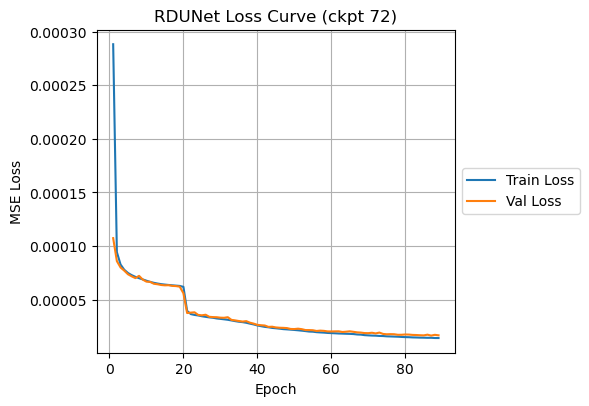

In [10]:
#!/usr/bin/env python

import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# ─── MODEL DEFINITIONS (RDUNet-style) ────────────────────────────────────────

@torch.no_grad()
def init_weights(init_type='xavier'):
    if init_type == 'xavier':
        init = nn.init.xavier_normal_
    elif init_type == 'he':
        init = nn.init.kaiming_normal_
    else:
        init = nn.init.orthogonal_

    def initializer(m):
        classname = m.__class__.__name__
        if classname.find('Conv2d') != -1:
            init(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight, 1.0, 0.01)
            nn.init.zeros_(m.bias)

    return initializer


class ResidualDenseBlock(nn.Module):
    """
    RD block: small dense block with local residual.
    """
    def __init__(self, in_ch, growth_rate=32, num_layers=4):
        super().__init__()
        self.in_ch = in_ch
        self.growth_rate = growth_rate
        self.num_layers = num_layers

        layers = []
        ch = in_ch
        for _ in range(num_layers):
            layers.append(nn.Conv2d(ch, growth_rate, kernel_size=3, padding=1))
            ch += growth_rate
        self.layers = nn.ModuleList(layers)

        self.lrelu = nn.ReLU(inplace=True)
        # compress back to in_ch
        self.conv_1x1 = nn.Conv2d(ch, in_ch, kernel_size=1)

    def forward(self, x):
        feats = [x]
        for conv in self.layers:
            out = conv(torch.cat(feats, dim=1))
            out = self.lrelu(out)
            feats.append(out)
        out = torch.cat(feats, dim=1)
        out = self.conv_1x1(out)
        return x + out  # local residual


class EncoderBlock(nn.Module):
    """
    Encoder stage: RD blocks + strided conv downsampling.
    """
    def __init__(self, in_ch, out_ch, num_rdb=2, growth_rate=32):
        super().__init__()
        self.rdbs = nn.Sequential(*[
            ResidualDenseBlock(in_ch, growth_rate=growth_rate)
            for _ in range(num_rdb)
        ])
        self.down = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.rdbs(x)
        skip = x
        x = self.down(x)
        return x, skip


class DecoderBlock(nn.Module):
    """
    Decoder stage: upsample + skip concat + RD blocks.
    """
    def __init__(self, in_ch, out_ch, num_rdb=2, growth_rate=32):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.reduce = nn.Conv2d(out_ch * 2, out_ch, kernel_size=1)
        self.rdbs = nn.Sequential(*[
            ResidualDenseBlock(out_ch, growth_rate=growth_rate)
            for _ in range(num_rdb)
        ])

    def forward(self, x, skip):
        x = self.up(x)
        # in case of 1-pixel mismatches, center-crop skip
        if x.shape[-2:] != skip.shape[-2:]:
            dh = skip.shape[-2] - x.shape[-2]
            dw = skip.shape[-1] - x.shape[-1]
            top = max(dh // 2, 0)
            left = max(dw // 2, 0)
            skip = skip[..., top:top + x.shape[-2], left:left + x.shape[-1]]
        x = torch.cat([x, skip], dim=1)
        x = self.reduce(x)
        x = self.rdbs(x)
        return x


class RDUNet(nn.Module):
    """
    RDUNet-style residual dense U-Net for denoising.

    - channels: 1 for grayscale DPs
    - forward(x) returns the *denoised* image using global residual:
          denoised = x - F(x)
      where F(x) is the predicted noise.
    """
    def __init__(self,
                 channels=1,
                 base_ch=64,
                 growth_rate=32,
                 num_rdb=2):
        super().__init__()

        self.head = nn.Conv2d(channels, base_ch, kernel_size=3, padding=1)

        # Encoder
        self.enc1 = EncoderBlock(base_ch,   base_ch * 2,
                                 num_rdb=num_rdb, growth_rate=growth_rate)
        self.enc2 = EncoderBlock(base_ch*2, base_ch * 4,
                                 num_rdb=num_rdb, growth_rate=growth_rate)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ResidualDenseBlock(base_ch * 4, growth_rate=growth_rate),
            ResidualDenseBlock(base_ch * 4, growth_rate=growth_rate),
        )

        # Decoder
        self.dec2 = DecoderBlock(base_ch * 4, base_ch * 2,
                                 num_rdb=num_rdb, growth_rate=growth_rate)
        self.dec1 = DecoderBlock(base_ch * 2, base_ch,
                                 num_rdb=num_rdb, growth_rate=growth_rate)

        self.tail = nn.Conv2d(base_ch, channels, kernel_size=3, padding=1)

    def forward(self, x):
        inp = x

        x = self.head(x)

        x, skip1 = self.enc1(x)   # 1st encoder stage
        x, skip2 = self.enc2(x)   # 2nd encoder stage

        x = self.bottleneck(x)

        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)

        noise = self.tail(x)
        denoised = inp - noise     # global residual: predict noise
        return denoised


# ─── 0) HYPERPARAMETERS & PATHS ─────────────────────────────────────────────

clean_dir       = "/Users/ethan/Desktop/Materials Simulation MPhil Project/Generated DPs Clean 3"
noisy_dir       = "/Users/ethan/Desktop/Materials Simulation MPhil Project/Generated DPs Noisy 9"

epochs          = 89
batch_size      = 8
lr              = 1e-5
max_train_imgs  = 30000
patience        = 20  # early stopping

checkpoint_dir  = "/Users/ethan/Desktop/Materials Simulation MPhil Project/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print("Hyperparameters:")
print(f"   epochs         = {epochs}")
print(f"   batch_size     = {batch_size}")
print(f"   learning_rate  = {lr}")
print(f"   max_train_imgs = {max_train_imgs}")
print(f"   checkpoint_dir = {checkpoint_dir}")
print(f"   early stopping patience = {patience}\n")


# ─── 1) DEVICE ───────────────────────────────────────────────────────────────

device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}\n")


# ─── 2) CROP TO MULTIPLE OF 4 ────────────────────────────────────────────────

class CenterCropToMultipleOf4:
    def __call__(self, img):
        # img is PIL Image (W, H)
        w, h = img.size
        new_h = h - (h % 4)
        new_w = w - (w % 4)

        left   = (w - new_w) // 2
        top    = (h - new_h) // 2
        right  = left + new_w
        bottom = top + new_h

        return img.crop((left, top, right, bottom))


# ─── 3) PAIR CLEAN / NOISY FILES ─────────────────────────────────────────────

def strip_suffix(fn):
    return fn.replace("_clear.png", "").replace("_noisy.png", "")

clean_files = sorted(f for f in os.listdir(clean_dir) if f.endswith(".png"))
noisy_files = sorted(f for f in os.listdir(noisy_dir) if f.endswith(".png"))

cb = {strip_suffix(f): f for f in clean_files}
nb = {strip_suffix(f): f for f in noisy_files}
keys = sorted(set(cb) & set(nb))

clean_paths = [os.path.join(clean_dir, cb[k]) for k in keys]
noisy_paths = [os.path.join(noisy_dir, nb[k]) for k in keys]

print(f"Found {len(keys)} matched clean/noisy pairs.\n")
if len(keys) == 0:
    raise RuntimeError("No matched clean/noisy PNG pairs found. Check your directories and filenames.")


# ─── 4) DATASET & DATALOADER ────────────────────────────────────────────────

class DPDenoiseDataset(Dataset):
    def __init__(self, noisy_paths, clean_paths, transform=None):
        self.noisy = noisy_paths
        self.clean = clean_paths
        self.tf    = transform

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        n = Image.open(self.noisy[idx]).convert("L")
        c = Image.open(self.clean[idx]).convert("L")
        if self.tf:
            n = self.tf(n)
            c = self.tf(c)
        return n, c


tfm = transforms.Compose([
    CenterCropToMultipleOf4(),
    transforms.ToTensor(),
])

train_n, val_n, train_c, val_c = train_test_split(
    noisy_paths, clean_paths, test_size=0.2, random_state=42
)

train_n, train_c = train_n[:max_train_imgs], train_c[:max_train_imgs]

train_ds = DPDenoiseDataset(train_n, train_c, tfm)
val_ds   = DPDenoiseDataset(val_n,   val_c,   tfm)

train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}\n")


# ─── 5) RDUNet MODEL ─────────────────────────────────────────────────────────

model = RDUNet(channels=1, base_ch=64, growth_rate=32, num_rdb=2).to(device)
model.apply(init_weights('xavier'))

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


# ─── 6) CHECKPOINT HANDLING ──────────────────────────────────────────────────

use_prev = input("Use previous checkpoint? (Y/N): ").strip().upper()
if use_prev == "Y":
    ver_prev = int(input("   Enter version to resume (e.g. 27): ").strip())
    resume_path = os.path.join(checkpoint_dir, f"dranet_checkpoint{ver_prev:02d}.pth")
    if not os.path.isfile(resume_path):
        print(f"Warning: {resume_path} not found → training from scratch.\n")
        start_epoch, train_losses, val_losses = 1, [], []
        ver_save = ver_prev
        save_path = os.path.join(checkpoint_dir, f"dranet_checkpoint{ver_save:02d}.pth")
    else:
        overwrite = input("   Overwrite this same version? (Y/N): ").strip().upper()
        ver_save = ver_prev if overwrite == "Y" else int(input("   Enter new save version: ").strip())
        save_path = os.path.join(checkpoint_dir, f"dranet_checkpoint{ver_save:02d}.pth")

        ck = torch.load(resume_path, map_location=device)
        model.load_state_dict(ck['model_state_dict'], strict=False)
        optimizer.load_state_dict(ck['optimizer_state_dict'])
        start_epoch  = ck.get('epoch', 0) + 1
        train_losses = ck.get('train_losses', [])
        val_losses   = ck.get('val_losses',   [])
        print(f"Resumed v{ver_prev} at epoch {start_epoch-1}, will save v{ver_save}\n")
else:
    ver_save = int(input("   Enter initial save version (e.g. 01): ").strip())
    save_path = os.path.join(checkpoint_dir, f"dranet_checkpoint{ver_save:02d}.pth")
    start_epoch = 1
    train_losses, val_losses = [], []
    print(f"Training from scratch → will save v{ver_save}\n")


# ─── 7) TRAIN LOOP WITH EARLY STOPPING ──────────────────────────────────────

best_val_loss = float("inf")
epochs_no_improve = 0
early_stop_triggered = False

for ep in range(start_epoch, epochs + 1):
    if early_stop_triggered:
        print(f"Early stopping triggered at epoch {ep-1}. Best val loss: {best_val_loss:.6f}")
        break

    # — train —
    model.train()
    tL = 0.0
    for noisy, clean in tqdm(train_ld, desc=f"Train {ep}/{epochs}"):
        noisy, clean = noisy.to(device), clean.to(device)
        den_pred = model(noisy)          # RDUNet outputs *denoised* image (x - noise)
        loss     = criterion(den_pred, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tL += loss.item()
    tL /= len(train_ld)
    train_losses.append(tL)

    # — val —
    model.eval()
    vL = 0.0
    with torch.no_grad():
        for noisy, clean in val_ld:
            noisy, clean = noisy.to(device), clean.to(device)
            den_pred = model(noisy)
            vL += criterion(den_pred, clean).item()
    vL /= len(val_ld)
    val_losses.append(vL)

    print(f"[Epoch {ep:03d}] Train L={tL:.6f}, Val L={vL:.6f}")

    # Early stopping logic
    if vL < best_val_loss - 1e-6:
        best_val_loss = vL
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"   No improvement for {epochs_no_improve}/{patience} epochs.")
        if epochs_no_improve >= patience:
            early_stop_triggered = True

    # Save checkpoint
    torch.save({
        'epoch':                ep,
        'model_state_dict':     model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses':         train_losses,
        'val_losses':           val_losses,
    }, save_path)
    if ep == epochs or early_stop_triggered:
        print(f"   Saved checkpoint: {save_path}\n")


# ─── 8) FINAL LOSS PLOT ─────────────────────────────────────────────────────

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.title(f"RDUNet Loss Curve (ckpt {ver_save:02d})")
plt.show()

# 3. NMC 811 Evaluation (Validation)

In [16]:
#!/usr/bin/env python
"""
Five-panel visualisation WITH coloured ring overlay
(a) noisy
(b) ring-masked noisy
(c) log(ring)
(d) denoised ring
(e) log(denoised)
"""

import math
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F  # kept for completeness
from torchvision import transforms
from matplotlib.patches import Circle


# ───────────────────── MODEL DEFINITIONS (same RDUNet as training) ───────────

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_ch, growth_rate=32, num_layers=4):
        super().__init__()
        self.in_ch = in_ch
        layers = []
        ch = in_ch
        for _ in range(num_layers):
            layers.append(nn.Conv2d(ch, growth_rate, kernel_size=3, padding=1))
            ch += growth_rate
        self.layers = nn.ModuleList(layers)
        self.lrelu = nn.ReLU(inplace=True)
        self.conv_1x1 = nn.Conv2d(ch, in_ch, kernel_size=1)

    def forward(self, x):
        feats = [x]
        for conv in self.layers:
            out = conv(torch.cat(feats, dim=1))
            out = self.lrelu(out)
            feats.append(out)
        out = torch.cat(feats, dim=1)
        out = self.conv_1x1(out)
        return x + out


class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_rdb=2, growth_rate=32):
        super().__init__()
        self.rdbs = nn.Sequential(*[
            ResidualDenseBlock(in_ch, growth_rate=growth_rate)
            for _ in range(num_rdb)
        ])
        self.down = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.rdbs(x)
        skip = x
        x = self.down(x)
        return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_rdb=2, growth_rate=32):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.reduce = nn.Conv2d(out_ch * 2, out_ch, kernel_size=1)
        self.rdbs = nn.Sequential(*[
            ResidualDenseBlock(out_ch, growth_rate=growth_rate)
            for _ in range(num_rdb)
        ])

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            dh = skip.shape[-2] - x.shape[-2]
            dw = skip.shape[-1] - x.shape[-1]
            top = max(dh // 2, 0)
            left = max(dw // 2, 0)
            skip = skip[..., top:top + x.shape[-2], left:left + x.shape[-1]]
        x = torch.cat([x, skip], dim=1)
        x = self.reduce(x)
        x = self.rdbs(x)
        return x


class RDUNet(nn.Module):
    def __init__(self,
                 channels=1,
                 base_ch=64,
                 growth_rate=32,
                 num_rdb=2):
        super().__init__()

        self.head = nn.Conv2d(channels, base_ch, kernel_size=3, padding=1)

        self.enc1 = EncoderBlock(base_ch,   base_ch * 2,
                                 num_rdb=num_rdb, growth_rate=growth_rate)
        self.enc2 = EncoderBlock(base_ch*2, base_ch * 4,
                                 num_rdb=num_rdb, growth_rate=growth_rate)

        self.bottleneck = nn.Sequential(
            ResidualDenseBlock(base_ch * 4, growth_rate=growth_rate),
            ResidualDenseBlock(base_ch * 4, growth_rate=growth_rate),
        )

        self.dec2 = DecoderBlock(base_ch * 4, base_ch * 2,
                                 num_rdb=num_rdb, growth_rate=growth_rate)
        self.dec1 = DecoderBlock(base_ch * 2, base_ch,
                                 num_rdb=num_rdb, growth_rate=growth_rate)

        self.tail = nn.Conv2d(base_ch, channels, kernel_size=3, padding=1)

    def forward(self, x):
        inp = x
        x = self.head(x)
        x, skip1 = self.enc1(x)
        x, skip2 = self.enc2(x)
        x = self.bottleneck(x)
        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)
        noise = self.tail(x)
        return inp - noise  # denoised DP (residual)


# ───────────────────── CONFIG ─────────────────────

ROOT      = Path("/Users/ethan/Desktop/Materials Simulation MPhil Project")
CHKPT_DIR = ROOT / "checkpoints"
IMG_DIR   = ROOT / "dpc_pixel"
FIG_ROOT  = ROOT / "figures"
FIG_ROOT.mkdir(parents=True, exist_ok=True)

CHKPTS       = [72]   
PER_CKPT     = 588
IMGS_PER_FIG = 5
SEED         = 12345

INNER_R = 0.05
OUTER_R = 0.20
RING_COLORS = dict(inner="blue", outer="orange")

DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {DEVICE}")


# ───────────────────── TRANSFORMS ─────────────────────

class CenterCropToMultipleOf4:
    def __call__(self, img):
        w, h = img.size
        new_h = h - (h % 4)
        new_w = w - (w % 4)
        left   = (w - new_w) // 2
        top    = (h - new_h) // 2
        right  = left + new_w
        bottom = top + new_h
        return img.crop((left, top, right, bottom))


TFM = transforms.Compose([
    CenterCropToMultipleOf4(),
    transforms.ToTensor(),
])


# ───────────────────── UTILS ─────────────────────

def load_gray(p: Path) -> torch.Tensor:
    img = Image.open(p).convert("L")
    img = TFM(img)
    return img.unsqueeze(0).to(DEVICE)  # 1×1×H×W


def make_ring_mask(h, w, inner=INNER_R, outer=OUTER_R, device="cpu"):
    yy, xx = torch.meshgrid(
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing="ij"
    )
    cy, cx = h // 2, w // 2
    rr2 = (yy - cy) ** 2 + (xx - cx) ** 2
    rmin2 = (min(h, w) * inner) ** 2
    rmax2 = (min(h, w) * outer) ** 2
    return ((rr2 > rmin2) & (rr2 < rmax2)).float()  # H×W


def to_log(arr, eps=1e-6):
    """
    Safe log transform:
    - clamp negatives to 0
    - add eps to avoid log(0)
    - min-max normalise to [0, 1]
    """
    arr = np.asarray(arr)
    arr = np.maximum(arr, 0.0)
    lg = np.log(arr + eps)
    lg_min = lg.min()
    lg_max = lg.max()
    if lg_max - lg_min < 1e-12:
        return np.zeros_like(lg)
    return (lg - lg_min) / (lg_max - lg_min)


def draw_ring(ax, h, w):
    cy, cx = h / 2, w / 2
    for r, col in ((INNER_R, RING_COLORS["inner"]),
                   (OUTER_R, RING_COLORS["outer"])):
        circ = Circle(
            (cx, cy),
            r * min(h, w),
            fill=False,
            color=col,
            linewidth=1.2
        )
        ax.add_patch(circ)


@torch.no_grad()
def denoise_ring(model, img_path: Path):
    noisy = load_gray(img_path)          # 1×1×H×W (0–1 from ToTensor)
    H, W = noisy.shape[-2:]
    mask = make_ring_mask(H, W, device=noisy.device)   # H×W
    mask_4d = mask.unsqueeze(0).unsqueeze(0)           # 1×1×H×W

    # Section out only the ring
    noisy_ring = noisy * mask_4d

    # RDUNet residual denoising on the ring only
    den = model(noisy_ring)

    # Clamp to [0, 1] to avoid negative intensities before log transform
    den = den.clamp(min=0.0, max=1.0) * mask_4d

    return (
        noisy.squeeze().cpu().numpy(),        # full noisy DP
        noisy_ring.squeeze().cpu().numpy(),   # ring-masked noisy DP
        den.squeeze().cpu().numpy()           # ring-masked denoised DP
    )


# ───────────────────── MAIN ─────────────────────

def main():
    imgs = sorted([
        p for p in IMG_DIR.iterdir()
        if p.suffix.lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
    ])
    assert imgs, f"No images found in {IMG_DIR}"

    random.seed(SEED)

    # Ring labels like "8-25" for INNER_R=0.08, OUTER_R=0.25
    inner_pct = int(round(INNER_R * 100))
    outer_pct = int(round(OUTER_R * 100))

    for ver in CHKPTS:
        # Folder name: "69 denoise 8-25"
        out_dir = FIG_ROOT / f"{ver:02d} denoise {inner_pct}-{outer_pct}"
        out_dir.mkdir(parents=True, exist_ok=True)

        ckpt = CHKPT_DIR / f"dranet_checkpoint{ver:02d}.pth"
        if not ckpt.exists():
            print("skip", ckpt)
            continue

        print(f"\nLoading checkpoint {ckpt}")
        print(f"Output directory: {out_dir}")
        model = RDUNet(channels=1, base_ch=64, growth_rate=32, num_rdb=2).to(DEVICE)
        state = torch.load(ckpt, map_location=DEVICE)
        model.load_state_dict(state["model_state_dict"], strict=False)
        model.eval()

        # Create per-panel subfolders: image_a, image_b, ..., inside this out_dir
        panel_ids = ['a', 'b', 'c', 'd', 'e']
        panel_dirs = {
            pid: out_dir / f"image_{pid}"
            for pid in panel_ids
        }
        for d in panel_dirs.values():
            d.mkdir(parents=True, exist_ok=True)

        random.seed(SEED + ver)
        subset = random.sample(imgs, min(PER_CKPT, len(imgs)))
        pages = math.ceil(len(subset) / IMGS_PER_FIG)

        titles = [
            "Noisy DP",
            "Sectioned Noisy DP",
            "Log (Sectioned Noisy DP)",
            "Denoised DP",
            "Log (Denoised DP)",
        ]
        labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

        for page in range(pages):
            fig, axs = plt.subplots(
                5, IMGS_PER_FIG,
                figsize=(IMGS_PER_FIG * 3, 5 * 3),
                squeeze=False
            )
            axs = np.array(axs)

            for col in range(IMGS_PER_FIG):
                i = page * IMGS_PER_FIG + col
                if i >= len(subset):
                    break

                img_p = subset[i]
                no, ring_no, de = denoise_ring(model, img_p)

                images = [no, ring_no, to_log(ring_no), de, to_log(de)]

                # Save each panel (without rings) in its own folder:
                # e.g. "image_a/name_a.png", "image_b/name_b.png", ...
                for arr, pid in zip(images, panel_ids):
                    out_name = f"{img_p.stem}_{pid}.png"
                    out_path = panel_dirs[pid] / out_name
                    plt.imsave(out_path, np.clip(arr, 0, 1), cmap="gray")

                # Composite figure with rings
                for row in range(5):
                    ax = axs[row, col]
                    arr = images[row]

                    ax.imshow(arr, cmap="gray", vmin=0, vmax=1)

                    if row in {1, 2, 3, 4}:
                        draw_ring(ax, *arr.shape)

                    ax.set_title(titles[row], fontsize=16)
                    ax.text(
                        0.02, 0.95, labels[row],
                        transform=ax.transAxes,
                        fontsize=12, color='white',
                        weight='bold', va='top', ha='left'
                    )

                    if row == 0:
                        ax.text(
                            0.98, 0.95, img_p.name, color='white',
                            fontsize=12, transform=ax.transAxes,
                            ha='right', va='top'
                        )

                    ax.axis("off")

            fig.suptitle(
                f"RDUNet – Experimental Image Denoising (ckpt {ver:02d})",
                fontsize=16
            )
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            out_png = out_dir / f"ckpt{ver:02d}_page_{page+1}.png"
            plt.savefig(out_png, dpi=200)
            plt.close(fig)
            print("✓ saved", out_png)

        print(f"✓ saved composite pages and per-panel images in {out_dir}")


if __name__ == "__main__":
    main()

Using device: mps

Loading checkpoint /Users/ethan/Desktop/Materials Simulation MPhil Project/checkpoints/dranet_checkpoint72.pth
Output directory: /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_1.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_2.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_3.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_4.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_5.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_6.png
✓ saved /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/ckpt72_page_7.png
✓ saved /Users/ethan/Desktop/M

# 4. Phase Idnetification 

In [17]:
import os
import glob
import math
import re
import time
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from tqdm import tqdm

from openpyxl import Workbook
from openpyxl.styles import Font, Alignment


# ============================================================
# CONFIG
# ============================================================

IMAGE_GLOB = r"/Users/ethan/Desktop/Materials Simulation MPhil Project/figures/72 denoise 5-20/image_d/*.png"
OUT_ROOT_BASE = "/Users/ethan/Desktop/Materials Simulation MPhil Project/figures/hexagon_outputs"

CAT_NO_HEX = "no_hex"
CAT_HEX_NOT_O1O3 = "yes_hex_but_not_o1_nor_o3"
CAT_O1_ONLY = "o1_only"
CAT_O3_ONLY = "o3_only"
CAT_O1_O3 = "o1_and_o3"
TIMEOUT_CATEGORY = "skipped_timeout"

WRITE_OVERLAYS = True
SHOW_PANEL_TITLES = True
SHOW_LEGEND = True

# ---- Hard time limits ----
MAX_SECONDS_PER_IMAGE = 30.0
MAX_SECONDS_MODEL_BUILD = 120.0
ENABLE_MODEL_BUILD = True

# ---- Normalisation ----
NORMALIZE_BY = "outer"  # "outer" uses r_orange; "blue" uses r_blue

# ---- Rings by colour ----
BLUE_LOWER = np.array([90, 80, 40], dtype=np.uint8)
BLUE_UPPER = np.array([140, 255, 255], dtype=np.uint8)
ORANGE_LOWER = np.array([10, 80, 40], dtype=np.uint8)
ORANGE_UPPER = np.array([25, 255, 255], dtype=np.uint8)

FALLBACK_BLUE_FRAC = 0.05
FALLBACK_ORANGE_FRAC = 0.20

# ---- Annulus / centre masks ----
ANN_INNER_MARGIN = 0.90
ANN_OUTER_MARGIN = 0.98
CENTRE_MAX_FRAC = 0.95

# ---- Spot detection (DoG + NMS) ----
SPOT_DOWNSAMPLE = 2          # set 1 for maximum sensitivity
DOG_SIGMA1 = 1.0
DOG_SIGMA2 = 2.2             # > sigma1
SPOT_NMS_KSIZE = 9           # local maxima window (odd)
SPOT_MIN_REL_ANNULUS = 0.015 # relative to max DoG in annulus
SPOT_MIN_REL_CENTRAL = 0.03
SPOT_TOPK_ANNULUS_ALL = 300
SPOT_TOPK_CENTRAL_ALL = 120
SPOT_MIN_SEP_PX = 6.0        # min spacing in original pixels

SUBPIX_REFINE = True
SUBPIX_WIN = 7               # odd window for centroiding

MAX_ANNULUS_SPOTS_FOR_HEX = 90

# ---- Hex detection (RANSAC regular hex) ----
MAX_HEXAGONS_RETURN = 3
MAX_PLOTTED_HEXAGONS = 2

HEX_MIN_MATCHED_VERTS = 4
HEX_MIN_MATCHED_FOR_TRAIN = 5
HEX_MATCH_TOL_FRAC = 0.10        # distance tol = frac * radius
HEX_R_TOL_FRAC = 0.10            # ring consistency for sampled points
HEX_ANG_TOL_DEG = 10.0
HEX_RANSAC_ITERS = 700
HEX_JACCARD_MAX = 0.50
HEX_SCORE_RMSE_FRAC = 0.06       # rmse must be <= frac * r

# ---- Model (learned on NORMALISED radii) ----
PHASE_MIN_TRAIN_IMAGES = 10
PHASE_TRIM_IQR = 2.0
KMEANS_ITERS = 60

# True  -> smaller cluster labelled O3
# False -> smaller cluster labelled O1 (swap)
LABEL_SMALL_AS_O3 = False

# USER REQUESTED
O1_MATCH_FRAC = 0.15
O3_MATCH_FRAC = 0.1

# ---- Plot styling ----
USED_SPOT_COLOUR = "magenta"
USED_SPOT_SIZE = 22
USED_SPOT_ALPHA = 0.95

ALL_SPOT_COLOUR = "lightgray"
ALL_SPOT_SIZE = 12
ALL_SPOT_ALPHA = 0.9

CENTRAL_SPOT_COLOUR = "orange"
CENTRAL_SPOT_MARKER = "^"
CENTRAL_SPOT_SIZE = 18
CENTRAL_SPOT_ALPHA = 0.9

PARTIAL_MATCHED_MARKER = "o"
PARTIAL_MATCHED_FACE = "white"
PARTIAL_MATCHED_EDGE = "black"
PARTIAL_MATCHED_SIZE = 55

PARTIAL_PRED_MARKER = "x"
PARTIAL_PRED_COLOUR = "red"
PARTIAL_PRED_SIZE = 70


# ============================================================
# Helpers
# ============================================================

def get_image_a_path(image_d_path: str) -> str:
    d_dir = os.path.dirname(image_d_path)
    a_dir = d_dir.replace(os.sep + "image_d", os.sep + "image_a")

    fn = os.path.basename(image_d_path)
    stem, ext = os.path.splitext(fn)

    if stem.endswith("_d"):
        fn_a = stem[:-2] + "_a" + ext
    elif stem.endswith("-d"):
        fn_a = stem[:-2] + "-a" + ext
    else:
        fn_a = fn

    return os.path.join(a_dir, fn_a)


def _norm_scale(r_blue, r_orange):
    if NORMALIZE_BY == "blue":
        return max(float(r_blue), 1e-9)
    return max(float(r_orange), 1e-9)


def _resize_mask(mask, new_w, new_h):
    return cv2.resize(mask.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)


def _gaussian(img, sigma):
    if sigma <= 0:
        return img
    k = int(2 * round(3 * sigma) + 1)
    return cv2.GaussianBlur(img, (k, k), sigmaX=sigma, sigmaY=sigma)


def _find_contours(mask_u8):
    res = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return res[-2]


def _fit_circle_from_mask(mask):
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)
    cnts = _find_contours(mask)
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea)
    (x, y), r = cv2.minEnclosingCircle(cnt)
    return float(x), float(y), float(r)


def detect_ring_centre_and_radii(panel_rgb):
    H, W = panel_rgb.shape[:2]
    hsv = cv2.cvtColor(panel_rgb, cv2.COLOR_RGB2HSV)

    mask_blue = cv2.inRange(hsv, BLUE_LOWER, BLUE_UPPER)
    mask_orange = cv2.inRange(hsv, ORANGE_LOWER, ORANGE_UPPER)

    blue_fit = _fit_circle_from_mask(mask_blue)
    orange_fit = _fit_circle_from_mask(mask_orange)

    if blue_fit is None or orange_fit is None:
        cx, cy = W / 2.0, H / 2.0
        r_blue = FALLBACK_BLUE_FRAC * min(H, W)
        r_orange = FALLBACK_ORANGE_FRAC * min(H, W)
        return (float(cx), float(cy)), float(r_blue), float(r_orange), True

    cx = 0.5 * (blue_fit[0] + orange_fit[0])
    cy = 0.5 * (blue_fit[1] + orange_fit[1])

    ys_b, xs_b = np.where(mask_blue > 0)
    ys_o, xs_o = np.where(mask_orange > 0)

    r_blue = float(np.median(np.sqrt((xs_b - cx) ** 2 + (ys_b - cy) ** 2))) if len(xs_b) else float(blue_fit[2])
    r_orange = float(np.median(np.sqrt((xs_o - cx) ** 2 + (ys_o - cy) ** 2))) if len(xs_o) else float(orange_fit[2])

    return (float(cx), float(cy)), r_blue, r_orange, False


def make_spot_annulus_mask(shape, centre, r_blue, r_orange,
                           inner_margin=ANN_INNER_MARGIN,
                           outer_margin=ANN_OUTER_MARGIN):
    H, W = shape[:2]
    cx, cy = centre
    Y, X = np.ogrid[:H, :W]
    R = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    r_inner = inner_margin * r_blue
    r_outer = outer_margin * r_orange
    return ((R >= r_inner) & (R <= r_outer)).astype(np.uint8)


def pixel_to_cartesian(pts_px, centre_px):
    pts_px = np.asarray(pts_px, dtype=float)
    if pts_px.size == 0:
        return np.empty((0, 2), dtype=float)
    cx, cy = centre_px
    x = pts_px[:, 0] - cx
    y = cy - pts_px[:, 1]
    return np.stack([x, y], axis=1)


def cartesian_to_pixel(pts_xy, centre_px):
    pts_xy = np.asarray(pts_xy, dtype=float)
    cx, cy = centre_px
    x_px = pts_xy[:, 0] + cx
    y_px = cy - pts_xy[:, 1]
    return np.stack([x_px, y_px], axis=1)


def angle_deg(xy):
    a = np.degrees(np.arctan2(xy[..., 1], xy[..., 0]))
    return np.mod(a, 360.0)


def wrap_angle_deg(a):
    return np.mod(a + 180.0, 360.0) - 180.0


def iqr_trim(values, k=2.0):
    v = np.asarray(values, dtype=float)
    v = v[np.isfinite(v)]
    if len(v) < 4:
        return v
    q1, q3 = np.percentile(v, [25, 75])
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return v[(v >= lo) & (v <= hi)]


def kmeans_1d_two_clusters(x, iters=60):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 2:
        return None

    c0, c1 = np.percentile(x, [30, 70])
    if np.isclose(c0, c1):
        return None

    for _ in range(iters):
        d0 = np.abs(x - c0)
        d1 = np.abs(x - c1)
        m0 = d0 <= d1
        m1 = ~m0
        if m0.sum() == 0 or m1.sum() == 0:
            break
        nc0 = x[m0].mean()
        nc1 = x[m1].mean()
        if np.isclose(nc0, c0) and np.isclose(nc1, c1):
            break
        c0, c1 = nc0, nc1

    return tuple(sorted([float(c0), float(c1)]))


# ============================================================
# Spot detection: DoG + NMS + optional subpixel centroid
# ============================================================

def _nms_peaks(score_img, mask_u8, ksize, min_rel, topk):
    masked = score_img.copy()
    masked[mask_u8 == 0] = 0.0
    vmax = float(masked.max())
    if vmax <= 1e-9:
        return np.empty((0, 2), dtype=float), np.empty((0,), dtype=float)

    thr = min_rel * vmax

    k = max(3, int(ksize) | 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    dil = cv2.dilate(masked, kernel)

    is_peak = (masked >= dil - 1e-12) & (masked >= thr) & (mask_u8 > 0)
    ys, xs = np.where(is_peak)
    if len(xs) == 0:
        return np.empty((0, 2), dtype=float), np.empty((0,), dtype=float)

    vals = masked[ys, xs]
    order = np.argsort(vals)[::-1]
    if topk is not None and len(order) > topk:
        order = order[:topk]

    xs = xs[order].astype(float)
    ys = ys[order].astype(float)
    vals = vals[order].astype(float)

    pts = np.stack([xs, ys], axis=1)
    return pts, vals


def _min_sep_filter(points, scores, min_sep):
    if len(points) == 0:
        return points, scores
    pts = np.asarray(points, dtype=float)
    sc = np.asarray(scores, dtype=float)
    order = np.argsort(sc)[::-1]
    pts = pts[order]
    sc = sc[order]

    kept_pts = []
    kept_sc = []
    for p, s in zip(pts, sc):
        ok = True
        for q in kept_pts:
            if np.linalg.norm(p - q) <= min_sep:
                ok = False
                break
        if ok:
            kept_pts.append(p)
            kept_sc.append(s)

    return np.asarray(kept_pts, dtype=float), np.asarray(kept_sc, dtype=float)


def _subpixel_centroid(gray_norm, pts_xy, win=7):
    H, W = gray_norm.shape
    r = int(win // 2)
    out = []
    for x, y in pts_xy:
        xi = int(round(x))
        yi = int(round(y))
        x0 = max(0, xi - r)
        x1 = min(W, xi + r + 1)
        y0 = max(0, yi - r)
        y1 = min(H, yi + r + 1)
        patch = gray_norm[y0:y1, x0:x1]
        if patch.size == 0:
            out.append([x, y])
            continue
        yy, xx = np.mgrid[y0:y1, x0:x1]
        w = patch.astype(float)
        wsum = float(w.sum())
        if wsum <= 1e-9:
            out.append([x, y])
            continue
        cx = float((xx * w).sum() / wsum)
        cy = float((yy * w).sum() / wsum)
        out.append([cx, cy])
    return np.asarray(out, dtype=float)


def detect_spots(panel_rgb, centre_px, r_blue, r_orange):
    gray = cv2.cvtColor(panel_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    gray_norm = (gray - gray.min()) / (gray.max() - gray.min() + 1e-9)

    H, W = gray_norm.shape
    ds = max(1, int(SPOT_DOWNSAMPLE))

    if ds > 1:
        new_w = max(16, W // ds)
        new_h = max(16, H // ds)
        g_ds = cv2.resize(gray_norm, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        new_h, new_w = H, W
        g_ds = gray_norm.copy()

    g1 = _gaussian(g_ds, DOG_SIGMA1)
    g2 = _gaussian(g_ds, DOG_SIGMA2)
    dog = (g1 - g2).astype(np.float32)
    dog = np.clip(dog, 0.0, None)

    ann_mask = make_spot_annulus_mask((H, W), centre_px, r_blue, r_orange,
                                      inner_margin=ANN_INNER_MARGIN,
                                      outer_margin=ANN_OUTER_MARGIN)
    ann_mask_ds = _resize_mask(ann_mask, new_w, new_h)

    cx, cy = centre_px
    Y, X = np.ogrid[:H, :W]
    R = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    cen_mask = (R <= CENTRE_MAX_FRAC * r_blue).astype(np.uint8)
    cen_mask_ds = _resize_mask(cen_mask, new_w, new_h)

    ann_pts_ds, ann_sc = _nms_peaks(dog, ann_mask_ds, SPOT_NMS_KSIZE, SPOT_MIN_REL_ANNULUS, SPOT_TOPK_ANNULUS_ALL)
    cen_pts_ds, cen_sc = _nms_peaks(dog, cen_mask_ds, SPOT_NMS_KSIZE, SPOT_MIN_REL_CENTRAL, SPOT_TOPK_CENTRAL_ALL)

    if ds > 1:
        ann_pts = ann_pts_ds * ds
        cen_pts = cen_pts_ds * ds
    else:
        ann_pts = ann_pts_ds
        cen_pts = cen_pts_ds

    ann_pts, ann_sc = _min_sep_filter(ann_pts, ann_sc, SPOT_MIN_SEP_PX)
    cen_pts, cen_sc = _min_sep_filter(cen_pts, cen_sc, SPOT_MIN_SEP_PX)

    if SUBPIX_REFINE and len(ann_pts):
        ann_pts = _subpixel_centroid(gray_norm, ann_pts, win=SUBPIX_WIN)
    if SUBPIX_REFINE and len(cen_pts):
        cen_pts = _subpixel_centroid(gray_norm, cen_pts, win=SUBPIX_WIN)

    if len(ann_pts) > MAX_ANNULUS_SPOTS_FOR_HEX:
        xs = np.clip(np.round(ann_pts[:, 0]).astype(int), 0, W - 1)
        ys = np.clip(np.round(ann_pts[:, 1]).astype(int), 0, H - 1)
        xs_ds = np.clip((xs / ds).astype(int), 0, new_w - 1)
        ys_ds = np.clip((ys / ds).astype(int), 0, new_h - 1)
        vals = dog[ys_ds, xs_ds]
        keep = np.argsort(vals)[::-1][:MAX_ANNULUS_SPOTS_FOR_HEX]
        ann_for_hex = ann_pts[keep]
    else:
        ann_for_hex = ann_pts.copy()

    return ann_pts, ann_for_hex, cen_pts, gray_norm


# ============================================================
# Hex detection: RANSAC fit of regular hexagon on a ring
# ============================================================

@dataclass
class HexCandidate:
    r_px: float
    r_norm: float
    phi_deg: float
    pred_vertices_px: np.ndarray
    match_indices: List[Optional[int]]
    matched_count: int
    rmse: float

    @property
    def kind(self):
        return "full" if self.matched_count == 6 else "partial"


def _predict_hex_vertices(centre_px, r_px, phi_deg):
    phi = float(phi_deg)
    angs = np.deg2rad((phi + np.arange(6) * 60.0) % 360.0)
    xy = np.stack([r_px * np.cos(angs), r_px * np.sin(angs)], axis=1)
    return cartesian_to_pixel(xy, centre_px)


def _match_vertices_to_points(pred_px, points_px, tol_px):
    pts = np.asarray(points_px, dtype=float)
    used = set()
    match_idx = []
    dists_used = []

    for v in pred_px:
        if len(pts) == 0:
            match_idx.append(None)
            continue
        d = np.linalg.norm(pts - v[None, :], axis=1)
        j = int(np.argmin(d))
        if float(d[j]) <= tol_px and j not in used:
            used.add(j)
            match_idx.append(j)
            dists_used.append(float(d[j]))
        else:
            match_idx.append(None)

    rmse = float(np.sqrt(np.mean(np.square(dists_used)))) if dists_used else 1e9
    matched = sum(m is not None for m in match_idx)
    return match_idx, rmse, matched


def _jaccard(a_idx, b_idx):
    a = {i for i in a_idx if i is not None}
    b = {i for i in b_idx if i is not None}
    if not a and not b:
        return 0.0
    inter = len(a & b)
    uni = len(a | b)
    return inter / uni if uni else 0.0


def find_hexagons_ransac(points_px, centre_px, scale_px, deadline=None) -> List[HexCandidate]:
    pts = np.asarray(points_px, dtype=float)
    if len(pts) < 4:
        return []

    cart = pixel_to_cartesian(pts, centre_px)
    rs = np.linalg.norm(cart, axis=1)
    thetas = angle_deg(cart)

    rng = np.random.default_rng(0)

    best: List[HexCandidate] = []

    def try_add(cand: HexCandidate):
        for existing in best:
            if _jaccard(existing.match_indices, cand.match_indices) > HEX_JACCARD_MAX:
                return
        best.append(cand)

    n = len(pts)
    for _ in range(HEX_RANSAC_ITERS):
        if deadline is not None and time.monotonic() > deadline:
            break

        i, j = rng.integers(0, n, size=2)
        if i == j:
            continue

        ri, rj = float(rs[i]), float(rs[j])
        if ri <= 1e-6 or rj <= 1e-6:
            continue

        r0 = 0.5 * (ri + rj)

        if abs(ri - rj) > HEX_R_TOL_FRAC * r0:
            continue

        ti, tj = float(thetas[i]), float(thetas[j])
        dtheta = wrap_angle_deg(tj - ti)

        ok = False
        for k in range(1, 6):
            target = k * 60.0
            if abs(abs(dtheta) - target) <= HEX_ANG_TOL_DEG:
                ok = True
                break
        if not ok:
            continue

        best_local = None
        for m in range(6):
            phi = (ti - m * 60.0) % 360.0
            pred = _predict_hex_vertices(centre_px, r0, phi)
            tol_px = HEX_MATCH_TOL_FRAC * r0
            match_idx, rmse, matched = _match_vertices_to_points(pred, pts, tol_px)

            if matched < HEX_MIN_MATCHED_VERTS:
                continue
            if rmse > HEX_SCORE_RMSE_FRAC * r0:
                continue

            key = (matched, -rmse)
            if best_local is None or key > best_local[0]:
                best_local = (key, phi, pred, match_idx, rmse, matched)

        if best_local is None:
            continue

        _, phi, _, match_idx, _, _ = best_local

        used = [idx for idx in match_idx if idx is not None]
        r_ref = float(np.median(rs[used])) if len(used) >= 3 else r0

        pred2 = _predict_hex_vertices(centre_px, r_ref, phi)
        tol2 = HEX_MATCH_TOL_FRAC * r_ref
        match_idx2, rmse2, matched2 = _match_vertices_to_points(pred2, pts, tol2)
        if matched2 < HEX_MIN_MATCHED_VERTS or rmse2 > HEX_SCORE_RMSE_FRAC * r_ref:
            continue

        cand = HexCandidate(
            r_px=r_ref,
            r_norm=float(r_ref / max(scale_px, 1e-9)),
            phi_deg=float(phi),
            pred_vertices_px=pred2,
            match_indices=[(int(x) if x is not None else None) for x in match_idx2],
            matched_count=int(matched2),
            rmse=float(rmse2),
        )
        try_add(cand)

        best.sort(key=lambda c: (-c.matched_count, c.rmse))
        best = best[:MAX_HEXAGONS_RETURN]

    best.sort(key=lambda c: (-c.matched_count, c.rmse))
    return best


# ============================================================
# Model build + classification
# ============================================================

def build_o3_o1_model(paths):
    if not ENABLE_MODEL_BUILD:
        return {"ok": False, "reason": "model_build_disabled", "r_o3": None, "r_o1": None, "n_train": 0}

    t0 = time.monotonic()
    used_images = 0
    all_r_norm = []

    for path in tqdm(paths, desc="Learning O3/O1 (RANSAC)", leave=False):
        if time.monotonic() - t0 > MAX_SECONDS_MODEL_BUILD:
            return {"ok": False, "reason": "model_build_time_budget_exceeded", "r_o3": None, "r_o1": None, "n_train": used_images}

        img_bgr = cv2.imread(path)
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        centre_px, r_blue, r_orange, _ = detect_ring_centre_and_radii(img_rgb)
        scale = _norm_scale(r_blue, r_orange)

        _, ann_for_hex, _, _ = detect_spots(img_rgb, centre_px, r_blue, r_orange)

        deadline = time.monotonic() + MAX_SECONDS_PER_IMAGE
        cands = find_hexagons_ransac(ann_for_hex, centre_px, scale, deadline=deadline)

        strong = [c for c in cands if c.matched_count >= HEX_MIN_MATCHED_FOR_TRAIN]
        if not strong:
            continue

        strong.sort(key=lambda c: (-c.matched_count, c.rmse))
        top = strong[:2]
        for c in top:
            all_r_norm.append(float(c.r_norm))
        used_images += 1

    if used_images < PHASE_MIN_TRAIN_IMAGES or len(all_r_norm) < 10:
        return {"ok": False, "reason": "not_enough_training_images", "r_o3": None, "r_o1": None, "n_train": used_images}

    all_r_t = iqr_trim(all_r_norm, k=PHASE_TRIM_IQR)
    if len(all_r_t) < 10:
        all_r_t = np.asarray(all_r_norm, dtype=float)

    km = kmeans_1d_two_clusters(all_r_t, iters=KMEANS_ITERS)
    if km is None:
        return {"ok": False, "reason": "kmeans_failed", "r_o3": None, "r_o1": None, "n_train": used_images}

    r_small_ref, r_large_ref = km
    if LABEL_SMALL_AS_O3:
        r_o3, r_o1 = r_small_ref, r_large_ref
    else:
        r_o3, r_o1 = r_large_ref, r_small_ref

    return {"ok": True, "reason": "ok", "r_o3": float(r_o3), "r_o1": float(r_o1), "n_train": used_images}


def classify_category(radii_norm, model):
    if radii_norm is None or len(radii_norm) == 0:
        return CAT_NO_HEX, False, False

    if model is None or (not model.get("ok", False)):
        return CAT_HEX_NOT_O1O3, False, False

    r_o3 = float(model["r_o3"])
    r_o1 = float(model["r_o1"])
    rs = np.asarray(radii_norm, dtype=float)

    tol_o3 = O3_MATCH_FRAC * r_o3
    tol_o1 = O1_MATCH_FRAC * r_o1

    has_o3 = False
    has_o1 = False

    for r in rs:
        d3 = abs(r - r_o3)
        d1 = abs(r - r_o1)
        m3 = d3 <= tol_o3
        m1 = d1 <= tol_o1

        if m3 and m1:
            # ambiguous: assign to closer only
            if d3 <= d1:
                has_o3 = True
            else:
                has_o1 = True
        elif m3:
            has_o3 = True
        elif m1:
            has_o1 = True

    if has_o1 and has_o3:
        return CAT_O1_O3, True, True
    if has_o1:
        return CAT_O1_ONLY, True, False
    if has_o3:
        return CAT_O3_ONLY, False, True
    return CAT_HEX_NOT_O1O3, False, False


def explain_reason(category, model, radii_norm_all, fallback_used):
    if category == TIMEOUT_CATEGORY:
        return "Skipped: timeout during hex detection."
    if category == CAT_NO_HEX:
        return "No hex lattice detected in annulus (RANSAC)."

    if model is None or (not model.get("ok", False)):
        why = "unknown" if model is None else model.get("reason", "unknown")
        return f"Model unavailable, so cannot label O1/O3 (model_reason={why})."

    r_o1 = float(model["r_o1"])
    r_o3 = float(model["r_o3"])
    tol_o1 = O1_MATCH_FRAC * r_o1
    tol_o3 = O3_MATCH_FRAC * r_o3

    rs = np.asarray(radii_norm_all, dtype=float)
    fb = " Ring radii used fallback." if fallback_used else ""

    if category == CAT_O1_O3:
        return f"Matched both O1 (±{O1_MATCH_FRAC:.0%}) and O3 (±{O3_MATCH_FRAC:.0%}).{fb}"
    if category == CAT_O1_ONLY:
        return f"Matched O1 (±{O1_MATCH_FRAC:.0%}) but no O3 match.{fb}"
    if category == CAT_O3_ONLY:
        return f"Matched O3 (±{O3_MATCH_FRAC:.0%}) but no O1 match.{fb}"

    rs_str = ",".join(f"{x:.4f}" for x in rs.tolist()[:8])
    if len(rs) > 8:
        rs_str += ",..."
    return (f"Detected radii(norm) [{rs_str}] do not match "
            f"O1={r_o1:.4f}±{tol_o1:.4f} nor O3={r_o3:.4f}±{tol_o3:.4f}.{fb}")


# ============================================================
# Plot helpers
# ============================================================

def build_overlay_legend_handles(show_other=True):
    handles = [
        Line2D([0], [0], color="cyan", lw=2.2, label="O3 hex (radius match)"),
        Line2D([0], [0], color="yellow", lw=2.2, label="O1 hex (radius match)"),
    ]
    if show_other:
        handles.append(Line2D([0], [0], color="lime", lw=2.2, label="Other hex (no match)"))

    handles += [
        Line2D([0], [0], color="blue", lw=1.6, label="Inner ring"),
        Line2D([0], [0], color="orange", lw=1.6, label="Outer ring"),
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor=USED_SPOT_COLOUR, markeredgecolor=USED_SPOT_COLOUR,
               markersize=6, label="Used vertices (matched)"),
        Line2D([0], [0], marker=PARTIAL_MATCHED_MARKER, linestyle="None",
               markerfacecolor=PARTIAL_MATCHED_FACE, markeredgecolor=PARTIAL_MATCHED_EDGE,
               markersize=7, label="Partial: matched vertices"),
        Line2D([0], [0], marker=PARTIAL_PRED_MARKER, linestyle="None",
               color=PARTIAL_PRED_COLOUR, markersize=7, label="Partial: predicted missing"),
    ]
    return handles


def build_points_legend_handles():
    return [
        Line2D([0], [0], color="blue", lw=1.6, label="Inner ring"),
        Line2D([0], [0], color="orange", lw=1.6, label="Outer ring"),
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor="lightgray", markeredgecolor="lightgray",
               markersize=6, label="All annulus spots (detected)"),
        Line2D([0], [0], marker=CENTRAL_SPOT_MARKER, linestyle="None",
               color=CENTRAL_SPOT_COLOUR, markersize=7, label="All central spots (detected)"),
        Line2D([0], [0], marker=PARTIAL_PRED_MARKER, linestyle="None",
               color=PARTIAL_PRED_COLOUR, markersize=7, label="Predicted missing (partial)"),
    ]


def colour_for_radius_norm(r_norm, model):
    if model is None or (not model.get("ok", False)):
        return "lime"
    r_o3 = float(model["r_o3"])
    r_o1 = float(model["r_o1"])

    # if ambiguous, colour by closer
    d3 = abs(r_norm - r_o3)
    d1 = abs(r_norm - r_o1)
    m3 = d3 <= O3_MATCH_FRAC * r_o3
    m1 = d1 <= O1_MATCH_FRAC * r_o1

    if m3 and m1:
        return "cyan" if d3 <= d1 else "yellow"
    if m3:
        return "cyan"
    if m1:
        return "yellow"
    return "lime"


def pick_lattices_to_plot(cands: List["HexCandidate"], model):
    if not cands:
        return [], False

    model_ok = bool(model and model.get("ok", False))
    if model_ok:
        r_o1 = float(model["r_o1"])
        r_o3 = float(model["r_o3"])
        tol_o1 = O1_MATCH_FRAC * r_o1
        tol_o3 = O3_MATCH_FRAC * r_o3

        o1 = [c for c in cands if abs(c.r_norm - r_o1) <= tol_o1]
        o3 = [c for c in cands if abs(c.r_norm - r_o3) <= tol_o3]

        def best_of(lst):
            if not lst:
                return None
            lst = sorted(lst, key=lambda c: (-c.matched_count, c.rmse))
            return lst[0]

        b1 = best_of(o1)
        b3 = best_of(o3)

        chosen = []
        if b1 is not None:
            chosen.append(b1)
        if b3 is not None and (b3 is not b1):
            chosen.append(b3)

        if chosen:
            return chosen[:MAX_PLOTTED_HEXAGONS], True

    cands = sorted(cands, key=lambda c: (-c.matched_count, c.rmse))
    return cands[:MAX_PLOTTED_HEXAGONS], False


def unique_points(points_px, tol_px=0.75):
    pts = np.asarray(points_px, dtype=float)
    if pts.size == 0:
        return pts
    kept = []
    for p in pts:
        ok = True
        for q in kept:
            if np.linalg.norm(p - q) <= tol_px:
                ok = False
                break
        if ok:
            kept.append(p)
    return np.asarray(kept, dtype=float)


# ============================================================
# Analyse one image + overlay
# ============================================================

def analyse_one(img_d_rgb, image_d_path, out_root, model):
    img_a_rgb = None
    image_a_path = get_image_a_path(image_d_path)
    if os.path.exists(image_a_path):
        a_bgr = cv2.imread(image_a_path)
        if a_bgr is not None:
            img_a_rgb = cv2.cvtColor(a_bgr, cv2.COLOR_BGR2RGB)

    centre_px, r_blue, r_orange, used_fallback = detect_ring_centre_and_radii(img_d_rgb)
    scale = _norm_scale(r_blue, r_orange)

    ann_all, ann_for_hex, cen_all, _ = detect_spots(img_d_rgb, centre_px, r_blue, r_orange)

    deadline = time.monotonic() + MAX_SECONDS_PER_IMAGE
    cands = find_hexagons_ransac(ann_for_hex, centre_px, scale, deadline=deadline)

    radii_norm_all = [float(c.r_norm) for c in cands]
    radii_px_all = [float(c.r_px) for c in cands]

    if len(cands) == 0:
        category = CAT_NO_HEX
    else:
        category, _, _ = classify_category(radii_norm_all, model)

    reason = explain_reason(category, model, radii_norm_all, used_fallback)

    out_dir = os.path.join(out_root, category)
    os.makedirs(out_dir, exist_ok=True)

    plot_list, suppress_other = pick_lattices_to_plot(cands, model)
    radii_norm_plotted = [float(c.r_norm) for c in plot_list]
    radii_px_plotted = [float(c.r_px) for c in plot_list]

    used_measured_pts = []
    used_predicted_pts = []

    for c in plot_list:
        col = colour_for_radius_norm(c.r_norm, model)
        if suppress_other and col == "lime":
            continue

        pred = c.pred_vertices_px
        for v_idx, m in enumerate(c.match_indices):
            if m is not None:
                used_measured_pts.append(ann_for_hex[m])
            else:
                used_predicted_pts.append(pred[v_idx])

    used_measured_pts = unique_points(np.array(used_measured_pts, dtype=float) if len(used_measured_pts) else np.empty((0, 2)))
    used_predicted_pts = unique_points(np.array(used_predicted_pts, dtype=float) if len(used_predicted_pts) else np.empty((0, 2)))

    if WRITE_OVERLAYS:
        if img_a_rgb is not None:
            fig = plt.figure(figsize=(18, 4))
            gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.72])
            ax_a = fig.add_subplot(gs[0, 0])
            ax_d = fig.add_subplot(gs[0, 1])
            ax_ov = fig.add_subplot(gs[0, 2])
            ax_pts = fig.add_subplot(gs[0, 3])
            ax_leg = fig.add_subplot(gs[0, 4])

            ax_a.imshow(img_a_rgb)
            ax_a.axis("off")
            if SHOW_PANEL_TITLES:
                ax_a.set_title("Original denoised (A)")
        else:
            fig = plt.figure(figsize=(14, 4))
            gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.72])
            ax_d = fig.add_subplot(gs[0, 0])
            ax_ov = fig.add_subplot(gs[0, 1])
            ax_pts = fig.add_subplot(gs[0, 2])
            ax_leg = fig.add_subplot(gs[0, 3])

        ax_d.imshow(img_d_rgb)
        ax_d.axis("off")
        if SHOW_PANEL_TITLES:
            ax_d.set_title("Log denoised (D)")

        ax_ov.imshow(img_d_rgb)
        ax_ov.axis("off")
        if SHOW_PANEL_TITLES:
            ax_ov.set_title("Hexagons found (RANSAC)")

        ax_ov.add_patch(Circle(centre_px, r_blue, fill=False, edgecolor="blue", linewidth=1))
        ax_ov.add_patch(Circle(centre_px, r_orange, fill=False, edgecolor="orange", linewidth=1))

        if len(used_measured_pts):
            ax_ov.scatter(used_measured_pts[:, 0], used_measured_pts[:, 1],
                          s=USED_SPOT_SIZE, c=USED_SPOT_COLOUR,
                          alpha=USED_SPOT_ALPHA, zorder=3)

        for c in plot_list:
            col = colour_for_radius_norm(c.r_norm, model)
            if suppress_other and col == "lime":
                continue

            pred = c.pred_vertices_px
            ax_ov.plot(np.r_[pred[:, 0], pred[0, 0]],
                       np.r_[pred[:, 1], pred[0, 1]],
                       c=col, linewidth=2.2, alpha=0.95, zorder=6)

            measured = []
            missing = []
            for v_idx, m in enumerate(c.match_indices):
                if m is not None:
                    measured.append(ann_for_hex[m])
                else:
                    missing.append(pred[v_idx])

            if measured:
                measured = np.array(measured, dtype=float)
                ax_ov.scatter(measured[:, 0], measured[:, 1],
                              s=PARTIAL_MATCHED_SIZE, marker=PARTIAL_MATCHED_MARKER,
                              c=PARTIAL_MATCHED_FACE, edgecolors=PARTIAL_MATCHED_EDGE,
                              linewidths=0.8, zorder=8)

            if missing:
                missing = np.array(missing, dtype=float)
                ax_ov.scatter(missing[:, 0], missing[:, 1],
                              s=PARTIAL_PRED_SIZE, marker=PARTIAL_PRED_MARKER,
                              c=PARTIAL_PRED_COLOUR, linewidths=1.3, zorder=9)

        ax_pts.axis("off")
        if SHOW_PANEL_TITLES:
            ax_pts.set_title("All detected spots (black canvas)")

        H, W = img_d_rgb.shape[:2]
        black = np.zeros((H, W, 3), dtype=np.uint8)
        ax_pts.imshow(black)
        ax_pts.set_xlim(0, W)
        ax_pts.set_ylim(H, 0)

        ax_pts.add_patch(Circle(centre_px, r_blue, fill=False, edgecolor="blue", linewidth=1))
        ax_pts.add_patch(Circle(centre_px, r_orange, fill=False, edgecolor="orange", linewidth=1))

        if len(ann_all):
            ax_pts.scatter(ann_all[:, 0], ann_all[:, 1],
                           s=ALL_SPOT_SIZE, c=ALL_SPOT_COLOUR,
                           alpha=ALL_SPOT_ALPHA, zorder=3)
        if len(cen_all):
            ax_pts.scatter(cen_all[:, 0], cen_all[:, 1],
                           s=CENTRAL_SPOT_SIZE, marker=CENTRAL_SPOT_MARKER,
                           c=CENTRAL_SPOT_COLOUR, alpha=CENTRAL_SPOT_ALPHA, zorder=3)
        if len(used_predicted_pts):
            ax_pts.scatter(used_predicted_pts[:, 0], used_predicted_pts[:, 1],
                           s=PARTIAL_PRED_SIZE, marker=PARTIAL_PRED_MARKER,
                           c=PARTIAL_PRED_COLOUR, linewidths=1.3, zorder=4)

        ax_leg.axis("off")
        if SHOW_LEGEND:
            leg1 = ax_leg.legend(
                handles=build_overlay_legend_handles(show_other=not suppress_other),
                loc="upper left",
                framealpha=0.9,
                fontsize=8,
                title="Overlay legend",
                title_fontsize=9,
            )
            ax_leg.add_artist(leg1)
            ax_leg.legend(
                handles=build_points_legend_handles(),
                loc="lower left",
                framealpha=0.9,
                fontsize=8,
                title="Spots legend",
                title_fontsize=9,
            )

        base = os.path.splitext(os.path.basename(image_d_path))[0]
        combined_path = os.path.join(out_dir, f"{base}_combined.png")
        plt.tight_layout()
        plt.savefig(combined_path, dpi=200)
        plt.close(fig)

    return {
        "filename": os.path.basename(image_d_path),
        "category": category,
        "reason": reason,
        "model_ok": bool(model and model.get("ok", False)),
        "model_reason": "" if model is None else model.get("reason", ""),
        "r_o1_norm": "" if not (model and model.get("ok", False)) else float(model["r_o1"]),
        "r_o3_norm": "" if not (model and model.get("ok", False)) else float(model["r_o3"]),
        "scale_px": float(scale),
        "normalise_by": NORMALIZE_BY,
        "used_fallback": bool(used_fallback),
        "radii_norm_all": radii_norm_all,
        "radii_px_all": radii_px_all,
        "radii_norm_plotted": radii_norm_plotted,
        "radii_px_plotted": radii_px_plotted,
    }


# ============================================================
# Excel writer
# ============================================================

def write_excel(results, out_root):
    xlsx_path = os.path.join(out_root, "dp_categories.xlsx")
    wb = Workbook()
    ws = wb.active
    ws.title = "categories"

    headers = [
        "filename", "category", "reason",
        "model_ok", "model_reason",
        "r_o1_norm", "r_o3_norm",
        "o1_tol_frac", "o3_tol_frac",
        "scale_px", "normalise_by", "used_fallback",
        "radii_norm_all", "radii_px_all",
        "radii_norm_plotted", "radii_px_plotted",
    ]
    ws.append(headers)

    for r in results:
        ws.append([
            r["filename"],
            r["category"],
            r["reason"],
            int(bool(r["model_ok"])),
            r.get("model_reason", ""),
            "" if r.get("r_o1_norm", "") == "" else float(r["r_o1_norm"]),
            "" if r.get("r_o3_norm", "") == "" else float(r["r_o3_norm"]),
            float(O1_MATCH_FRAC),
            float(O3_MATCH_FRAC),
            float(r.get("scale_px", 0.0)),
            r.get("normalise_by", NORMALIZE_BY),
            int(bool(r.get("used_fallback", False))),
            ",".join(f"{x:.5f}" for x in r.get("radii_norm_all", [])),
            ",".join(f"{x:.2f}" for x in r.get("radii_px_all", [])),
            ",".join(f"{x:.5f}" for x in r.get("radii_norm_plotted", [])),
            ",".join(f"{x:.2f}" for x in r.get("radii_px_plotted", [])),
        ])

    header_font = Font(bold=True)
    for col_idx in range(1, len(headers) + 1):
        cell = ws.cell(row=1, column=col_idx)
        cell.font = header_font
        cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

    widths = {
        "A": 22, "B": 24, "C": 75, "D": 10, "E": 30,
        "F": 12, "G": 12, "H": 10, "I": 10,
        "J": 12, "K": 12, "L": 12,
        "M": 34, "N": 28, "O": 34, "P": 28
    }
    for col, w in widths.items():
        ws.column_dimensions[col].width = w

    wb.save(xlsx_path)
    return xlsx_path


# ============================================================
# Grid chart (d_<row>_<col> ordering) + colourblind-friendly palette
# ============================================================

def parse_row_col_from_filename(filename: str) -> Optional[Tuple[int, int]]:
    base = os.path.basename(filename)
    m = re.search(r"^d_(\d+)_(\d+)_", base)  # works for d_0_5_d.png etc.
    if not m:
        return None
    return int(m.group(1)), int(m.group(2))


def grid_label_for_category(cat: str) -> str:
    if cat == CAT_O3_ONLY:
        return "O3"
    if cat == CAT_O1_ONLY:
        return "O1"
    if cat == CAT_O1_O3:
        return "BOTH"
    if cat == TIMEOUT_CATEGORY:
        return "TIMEOUT"
    if cat == CAT_HEX_NOT_O1O3:
        return "OTHER"
    return "NONE"


def _hex_to_rgb01(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)], dtype=float) / 255.0

def _rgb01_to_hex(rgb):
    rgb = np.clip(np.array(rgb) * 255.0, 0, 255).astype(int)
    return "#{:02X}{:02X}{:02X}".format(rgb[0], rgb[1], rgb[2])


def build_grid_chart(results: List[Dict], out_root: str) -> str:
    items = []
    for r in results:
        rc = parse_row_col_from_filename(r["filename"])
        if rc is None:
            continue
        row, col = rc
        items.append((row, col, grid_label_for_category(r["category"]), r["filename"]))

    if not items:
        return ""

    rows = sorted({it[0] for it in items})
    row_to_cols = {}
    for row in rows:
        cols = sorted({c for (rr, c, _, _) in items if rr == row})
        row_to_cols[row] = cols

    max_cols = max(len(row_to_cols[row]) for row in rows)

    # Okabe–Ito style colourblind-friendly palette:
    C_NONE  = "#FFFFFF"
    C_O1    = "#0072B2"  # blue
    C_O3    = "#D55E00"  # vermillion
    C_OTHER = "#009E73"  # bluish green
    C_TO    = "#7F7F7F"  # grey
    C_MISS  = "#F2F2F2"  # missing slot

    C_BOTH = _rgb01_to_hex(0.5 * (_hex_to_rgb01(C_O1) + _hex_to_rgb01(C_O3)))

    label_to_code = {
        "NONE": 0,
        "O1": 1,
        "O3": 2,
        "BOTH": 3,
        "OTHER": 4,
        "TIMEOUT": 5,
    }

    colors = [C_NONE, C_O1, C_O3, C_BOTH, C_OTHER, C_TO]
    cmap = ListedColormap(colors)
    cmap.set_bad(C_MISS)

    bounds = np.arange(-0.5, len(colors) + 0.5, 1.0)
    norm = BoundaryNorm(bounds, cmap.N)

    grid = np.full((len(rows), max_cols), np.nan, dtype=float)
    text = np.full((len(rows), max_cols), "", dtype=object)
    col_ids = np.full((len(rows), max_cols), "", dtype=object)

    lookup = {(row, col): label for (row, col, label, _) in items}

    for i, row in enumerate(rows):
        cols = row_to_cols[row]
        for j, col in enumerate(cols):
            label = lookup.get((row, col), "NONE")
            grid[i, j] = float(label_to_code[label])
            text[i, j] = label
            col_ids[i, j] = str(col)

    fig_w = max(8.0, 0.55 * max_cols)
    fig_h = max(3.5, 0.55 * len(rows))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    ax.imshow(grid, interpolation="nearest", aspect="auto", cmap=cmap, norm=norm)
    ax.set_title("O1/O3 grid (rows=d_<row>_xx, cols increasing)")

    ax.set_yticks(np.arange(len(rows)))
    ax.set_yticklabels([str(r) for r in rows])
    ax.set_ylabel("row index (first number)")

    ax.set_xticks(np.arange(max_cols))
    ax.set_xticklabels([str(i) for i in range(max_cols)])
    ax.set_xlabel("column position within row (sorted by xx)")

    for i in range(len(rows)):
        for j in range(max_cols):
            if np.isnan(grid[i, j]):
                continue
            ax.text(j, i, f"{text[i, j]}\n{col_ids[i, j]}",
                    ha="center", va="center", fontsize=8)

    ax.set_xticks(np.arange(-.5, max_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(rows), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.6)
    ax.tick_params(which="minor", bottom=False, left=False)

    legend_handles = [
        Patch(facecolor=C_NONE,  edgecolor="black", label="NONE"),
        Patch(facecolor=C_O1,    edgecolor="black", label="O1"),
        Patch(facecolor=C_O3,    edgecolor="black", label="O3"),
        Patch(facecolor=C_BOTH,  edgecolor="black", label="BOTH"),
        Patch(facecolor=C_OTHER, edgecolor="black", label="OTHER"),
        Patch(facecolor=C_TO,    edgecolor="black", label="TIMEOUT"),
        Patch(facecolor=C_MISS,  edgecolor="black", label="MISSING"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", framealpha=0.95, fontsize=8)

    out_path = os.path.join(out_root, "o1_o3_grid.png")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close(fig)
    return out_path


# ============================================================
# Run pipeline
# ============================================================

def process_checkpoint_figures(image_glob=IMAGE_GLOB, out_root_base=OUT_ROOT_BASE):
    paths = sorted(glob.glob(image_glob))
    if not paths:
        print("No images found:", image_glob)
        return

    first = paths[0]
    parent_dir = os.path.dirname(first)
    run_dir = os.path.dirname(parent_dir)
    run_name = os.path.basename(run_dir)

    out_root = os.path.join(out_root_base, run_name)
    os.makedirs(out_root, exist_ok=True)

    for cat in [CAT_NO_HEX, CAT_HEX_NOT_O1O3, CAT_O1_ONLY, CAT_O3_ONLY, CAT_O1_O3, TIMEOUT_CATEGORY]:
        os.makedirs(os.path.join(out_root, cat), exist_ok=True)

    model = build_o3_o1_model(paths)

    results = []
    for path in tqdm(paths, desc="Processing (RANSAC hex + O1/O3)", leave=True):
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        results.append(analyse_one(img_rgb, path, out_root, model))

    report_path = os.path.join(out_root, "dp_categories.txt")
    with open(report_path, "w", encoding="utf-8") as f:
        f.write("filename\tcategory\n")
        for r in results:
            f.write(f"{r['filename']}\t{r['category']}\n")

    xlsx_path = write_excel(results, out_root)
    grid_path = build_grid_chart(results, out_root)

    print("Wrote:", report_path)
    print("Wrote:", xlsx_path)
    if grid_path:
        print("Wrote:", grid_path)
    print("Model:", model)


if __name__ == "__main__":
    process_checkpoint_figures()

Processing (RANSAC hex + O1/O3): 100%|████████| 588/588 [03:19<00:00,  2.95it/s]


Wrote: /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/hexagon_outputs/72 denoise 5-20/dp_categories.txt
Wrote: /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/hexagon_outputs/72 denoise 5-20/dp_categories.xlsx
Wrote: /Users/ethan/Desktop/Materials Simulation MPhil Project/figures/hexagon_outputs/72 denoise 5-20/o1_o3_grid.png
Model: {'ok': True, 'reason': 'ok', 'r_o3': 0.94490976464077, 'r_o1': 0.5616582139763803, 'n_train': 106}
